## Investigating a Drop in User Engagement
by Zecai Liang

### Problem: 
rapid drop of weekly_active_user counts around 2014-08-01

### Hypothesis:
#### 1. drop of new users (NO)
#### 2. drop of active user of certain type(s) (YES)
   - language: 
       - (major) English 
       - (minor) French, Japanese, German
   - company: 
       - (major) company_id 1.0
       - (minor) company_id 4.0 
   
#### 3. drop of certain type(s) of event (YES)
   - login (major major)
   - message (major)
   - like (minor)
   - search (minor)
   - signup (no)
   
### Conclusion:
- Major drops in **login** and **message** related activities (so lacking the basic engagement)
- Majorly affect **company_id 1.0 and 4.0**
- Majorly affect following language: **English, French, Japanese, German**


### Future Direction:
- study the relationship between email sending and engagement (especially login activity)

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings 
warnings.filterwarnings('ignore')
%matplotlib inline

## Hypothesis 1: Drop of New Users (No)

- New uers between 2014-05-01 and 2014-08-31 doesn't share the same trend with weekly_active_users
- so the drop is due to engagement patterns of existing users

In [94]:
### load user data
df_user = pd.read_csv("data/yammer_users.csv")
## convert time to timestamp
df_user["created_at"] = pd.to_datetime(df_user["created_at"])
df_user["activated_at"] = pd.to_datetime(df_user["activated_at"])

### Accounts (if activated) are created and activated within the same day.
 
The average waiting time between account creation and activation is 88.5 second (see below).
So when considering new users, we can consider account activation only. (between 2013-01-01 and 2014-08-31)

(Text(0.5, 0, 'seconds'), Text(0, 0.5, 'counts'))

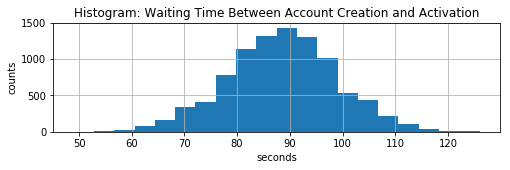

In [145]:
((df_user["activated_at"] - df_user["created_at"]).dropna() / pd.Timedelta(seconds=1))\ # timeDelta in seconds
                                                    .hist(bins = 20, figsize = (8,2))
plt.title("Histogram: Waiting Time Between Account Creation and Activation"), 
plt.xlabel("seconds"), plt.ylabel("counts")

### New user counts don't share the same trend with weekly_active_users

New users are stable with gradual increasing, so the fluctuation of weekly_active_users is not due to change of new users. (for the 18 weeks between 2014-05-01 and 2014-08-31)

Text(0, 0.5, 'counts')

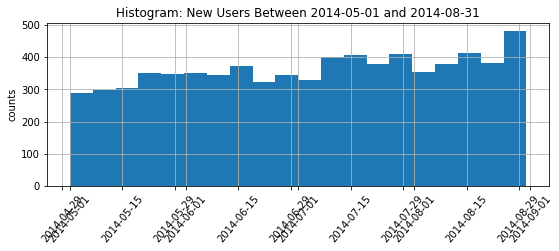

In [156]:
df_user["created_at"].hist(range = ("20140501", "20140831"), bins = 20, xrot = 50, figsize = (9,3))
plt.title("Histogram: New Users Between 2014-05-01 and 2014-08-31"), 
plt.ylabel("counts")

## Hypothesis 2: Drop of Active Users in Certain Segments

In [4]:
### load events data
df_event = pd.read_csv("data/yammer_events.csv")
## convert to timestamp
df_event["occurred_at"] = pd.to_datetime(df_event["occurred_at"])

In [137]:
## event_count: count event per week per user_id
df_week_event = df_event[["occurred_at", "user_id"]].groupby([df_event["occurred_at"].dt.week, "user_id"])["user_id"]\
                             .count().reset_index(name="event_count")
## add user company_id and language info (from df_user data)
df_week_user = df_week_event.join(df_user[["user_id", "company_id", "language"]], how = "left", on = "user_id", 
                    lsuffix = "_df_event", rsuffix = "_df_user")

### 2.1 drop of active users in language segments
- major drop in english, also majority of active users in english
- also drop in french, japanese, german(some)
- not drop in arabic

Text(0.5, 1.0, 'Weekly Active Users (Non-English)')

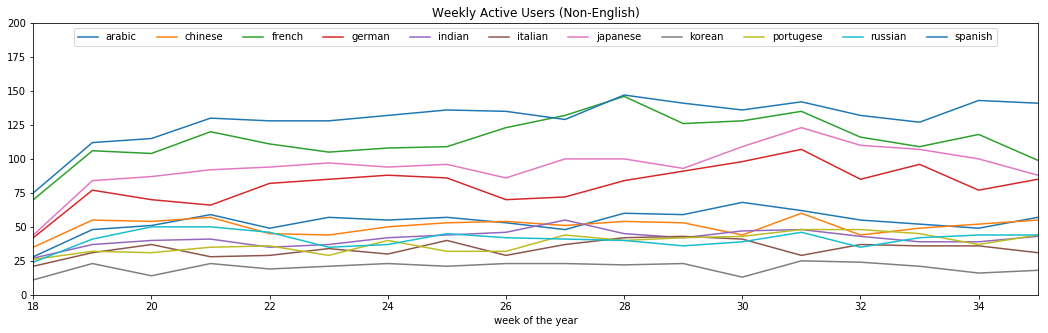

In [384]:
## weekly active users (non-english)
df = df_week_user.groupby(["occurred_at","language"])["user_id_df_event"].count().unstack()
df.loc[:, df.columns != 'english'].plot(kind='line', stacked=False, figsize = (18,5), ylim = (0,200))
plt.legend(loc = "upper center", ncol = 12), plt.xlabel("week of the year")
plt.title("Weekly Active Users (Non-English)")

Text(0.5, 1.0, 'Weekly Active Users (English)')

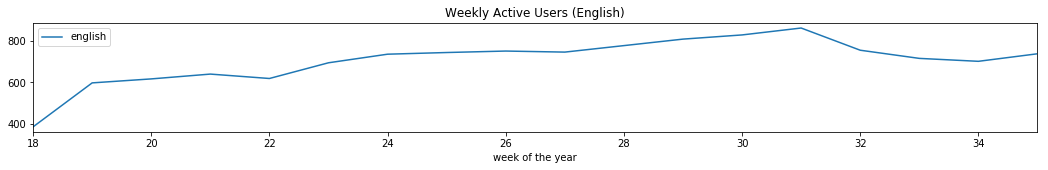

In [385]:
## english active users per week
df.loc[:, 'english'].plot(kind='line', stacked=False, figsize = (18,2))
plt.legend(loc = "upper left"), plt.xlabel("week of the year")
plt.title("Weekly Active Users (English)")

### 2.2 drop of active users in company segments
- Select top 5 companies with the most users (status: active), since there are 6950 unique company ids in total. 
- the major decline comes from company_id 1.0, and some from company_id 4.0

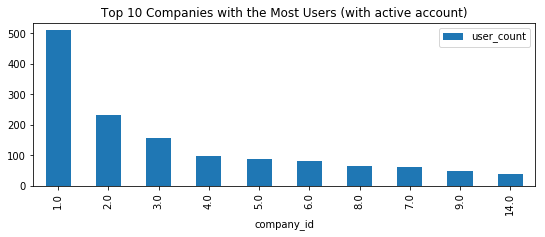

In [220]:
df = df_user[df_user["state"] == "active"].groupby("company_id")["user_id"].count().reset_index(name = "user_count")
df.sort_values("user_count", ascending = False).head(10).plot(x = "company_id", y = "user_count", \
                                                              kind = "bar", figsize = (9,3),
                                               title = "Top 10 Companies with the Most Users (with active account)")
top5_company_id = df["company_id"].head(5) # save company_id of top 5 companies with the most users

Text(0.5, 1.0, 'Weekly Events by Company')

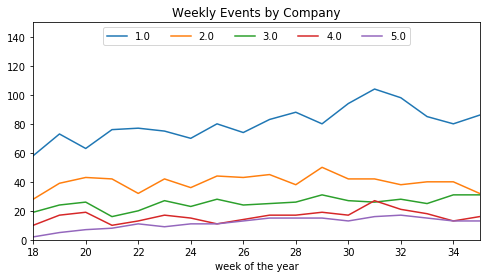

In [386]:
df = df_week_user[df_week_user["company_id"].isin(top5_company_id)]\
                                            .groupby(["occurred_at","company_id"])["user_id_df_event"]\
                                            .count().unstack().plot(ylim = (0,150), figsize = (8,4))
plt.legend(loc = "upper center", ncol = 5), plt.xlabel("week of the year")
plt.title("Weekly Events by Company")

## Hypothesis 3: Drop of Events in Certain Segments

### 3.1 drop of events by event type

- Further devide the event into 5 category by event_name:
   - signup: "create_user", "enter_email", "enter_info", "complete_signup"
   - login: "home_page", "login"
   - like: "like_message"
   - message: "send_message", "view_inbox"
   - search: "search_autocomplete", "search_run", "search_click_result_X"
 
 
- Major drop in "login" and "message"
- minor drop in "like" and "search"

In [367]:
## re-define event_type by event_name
event_name = {"signup": ["create_user", "enter_email", "enter_info", "complete_signup"],
              "login": ["home_page", "login"],
              "like": ["like_message"],
              "message": ["send_message", "view_inbox"]
              #"search": ["search_autocomplete", "search_run", "search_click_result_X"]    
}

for i in event_name:
    df_event.loc[df_event["event_name"].isin(event_name[i]),"event"] = i
df_event["event"] = df_event["event"].fillna("search") # the rest is "search"

In [371]:
df_event["event"].value_counts()

login      132675
message     89041
like        59248
search      40611
signup      19257
Name: event, dtype: int64

In [375]:
## count event per week per event type
df_event_type = df_event[["occurred_at", "event"]].groupby([df_event["occurred_at"].dt.week, "event"])["event"]\
                             .count().reset_index(name="event_count")

(<matplotlib.legend.Legend at 0x1a5fd2c908>, Text(0.5, 0, 'week of the year'))

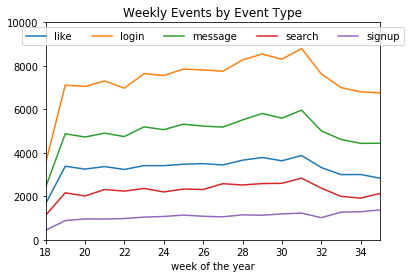

In [387]:
df_event_type.groupby(["occurred_at", "event"])["event_count"].sum().unstack() \
            .plot(kind = "line", title = "Weekly Events by Event Type", ylim = (0,10000))
plt.legend(loc = "upper center", ncol = 5), plt.xlabel("week of the year")